In [11]:
import numpy as np
import pandas as pd
from sklearn import cluster
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from tqdm import tqdm
import sklearn
from shapely.geometry import Polygon
from shapely import wkt
import re
import geopandas
from shapely import wkt
import random

# Uniquely Connected Counties

In the New York Times [write up](https://www.nytimes.com/interactive/2018/09/19/upshot/facebook-county-friendships.html) of county level Facebook friendship data, one section (*Where History Remains Visible*) pointed out some unexpected relationships between areas as a result of historical migrations:

>Northern cities like Chicago and Milwaukee still retain close ties to Southern counties along the Mississippi River, where African-American workers who were part of the Great Migration starting a century ago left communities for industrial jobs in the North. Kern County, Calif., holds ties today to counties in Oklahoma, where the Dust Bowl in the 1930s led to another significant migration (oil-producing Kern County today is also closely tied to parts of northwest North Dakota that are experiencing an oil boom).

I thought it would be interesting to algorithmically find unique relationships between counties. Here, I will approach this problem using 2 main steps:
1. Predict the social connectedness between countiesby using simple machine learning algorithms (linear regression and k-nearest neighbors)
2. Measure the difference between the expected number of friendships and the actual number of friendships. Then, the uniquely connected counties are those where the actual number of friendships is much greater than the expected.

## Data set up

In [12]:
# Read in some connectivity data, gathered from the previous scripts
county_conn_df = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\county_conn.pkl') 
sci_dist_df = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\sci_dist.pkl')
geo_dist = np.load(r'C:\Users\mgm24\Documents\datasets\geo_dist.npy')
sci_dist_df.head(5)

fr_loc,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
user_loc,,,,,,,,,,,,,,,,,,,,,
1001,1.117710e-07,9.804210e-06,7.443744e-06,3.927421e-06,1.488184e-05,2.330883e-06,0.000001,0.000014,0.000009,0.000028,...,0.000573,0.000597,0.000418,0.000810,0.000730,0.000561,0.000344,0.000731,0.001028,0.001453
1003,9.804210e-06,3.172975e-07,1.997443e-05,1.228879e-05,1.490024e-05,3.052969e-05,0.000006,0.000016,0.000025,0.000026,...,0.000805,0.000371,0.000298,0.000522,0.000279,0.000634,0.000158,0.000521,0.000717,0.000442
1005,7.443744e-06,1.997443e-05,2.212110e-08,3.133912e-05,5.388512e-05,1.598885e-07,0.000004,0.000018,0.000006,0.000060,...,0.000738,0.000713,0.001277,0.001645,0.001242,0.001695,0.000350,0.002358,0.001427,0.001580
1007,3.927421e-06,1.228879e-05,3.133912e-05,2.434424e-08,4.175470e-06,1.999440e-05,0.000008,0.000012,0.000028,0.000023,...,0.002273,0.000667,0.000647,0.001488,0.000774,0.001898,0.001058,0.001502,0.001391,0.001019
1009,1.488184e-05,1.490024e-05,5.388512e-05,4.175470e-06,7.533211e-08,7.212926e-05,0.000034,0.000005,0.000038,0.000006,...,0.002457,0.000709,0.000665,0.000320,0.001105,0.000487,0.000668,0.001079,0.000875,0.000513


In [13]:
# vectorize pairwise distances
sci_dist_df = pd.melt(sci_dist_df, ignore_index=False) 
sci_dist = np.asarray(sci_dist_df['value'])
geo_dist = geo_dist.reshape((geo_dist.shape[0]**2,1)) #this reorganizes elements in the same way as pd.melt
sci_dist_df.head(5)

,fr_loc,value
user_loc,,
1001,1001,1.117710e-07
1003,1001,9.804210e-06
1005,1001,7.443744e-06
1007,1001,3.927421e-06
1009,1001,1.488184e-05


In [14]:
# Convert sci_dist into a connectedness measure
sci_dist_df['geo_dist'] = geo_dist
sci_dist_df['SDI'] = sci_dist_df['value']
sci_dist_df['SCI'] = 1/sci_dist_df['value']
# sci = 1/sci_dist

## Linear regression

First, I'll try a simple linear regression, using the counties distance to predict their social connectedness. Let's look at our variables and make sure they're approximately normally distributed:

Text(0.5, 1.0, 'SCI')

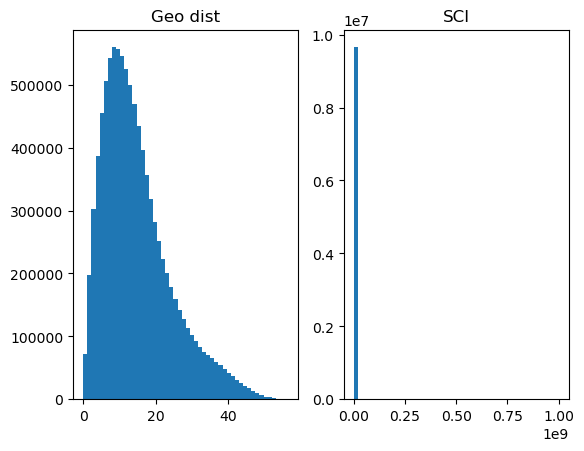

In [15]:
plt.subplot(1,2,1)
_ = plt.hist(sci_dist_df['geo_dist'], bins=50)
plt.title('Geo dist')
plt.subplot(1,2,2)
_ = plt.hist(sci_dist_df['SCI'], bins=50)
plt.title('SCI')

They are certainly not normally distributed! Let's take their logs:

C:\Users\mgm24\anaconda3\envs\DS_projects\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Log SCI')

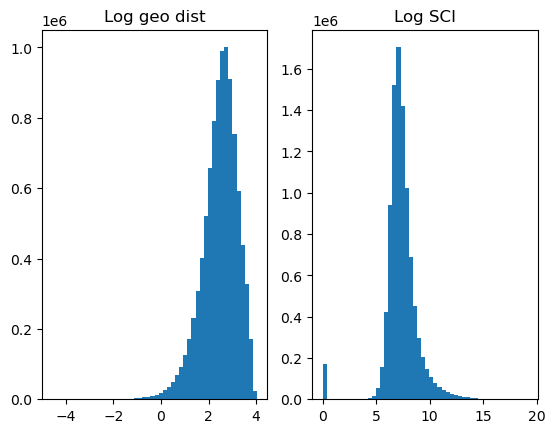

In [16]:
# Log scale
sci_dist_df = sci_dist_df[sci_dist_df['geo_dist']>0]
sci_dist_df['log_geo_dist'] = np.log(sci_dist_df['geo_dist'])
sci_dist_df['log_SCI'] = np.log(sci_dist_df['SCI'])
sci_dist_df['log_log_SCI'] = np.log(sci_dist_df['log_SCI'])
plt.subplot(1,2,1)
_ = plt.hist(sci_dist_df['log_geo_dist'], bins=50)
plt.title('Log geo dist')
plt.subplot(1,2,2)
_ = plt.hist(sci_dist_df['log_SCI'], bins=50)
plt.title('Log SCI')

The SCI is much better than before, and the geo distance is about the same. Let's also remove those outliers near 0 for SCI

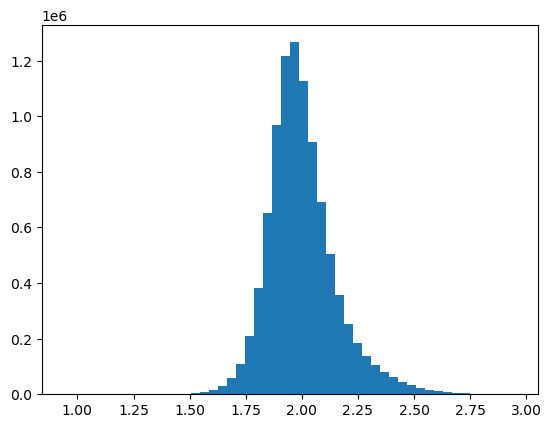

In [17]:
# Remove outliers
sci_dist_df = sci_dist_df[sci_dist_df['log_SCI']>.1]
_ = plt.hist(sci_dist_df['log_log_SCI'], bins=50)

Now, let's plot the relationship between the geographical distance and Social Connectedness Index: Since we're only interested in when social distance is unexpectadly small when the counties are geographically distant, we'll remove the counties where the geographical distance is small.

Samples with a distance greater than 4.511534669127608: 8707544


Text(0, 0.5, 'Social connectedness')

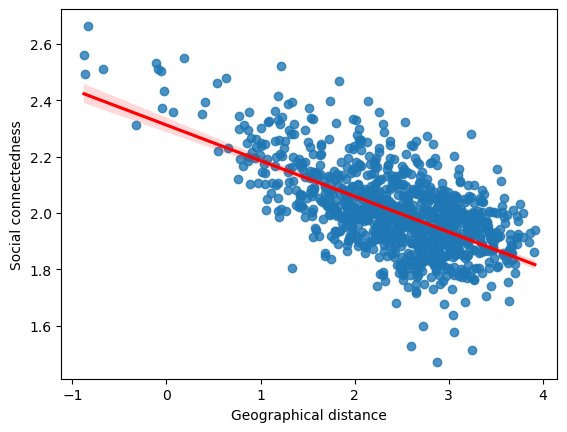

In [18]:
dist = np.percentile(sci_dist_df['geo_dist'], 10)
print('Samples with a distance greater than '+str(dist)+': '+ str(np.sum(geo_dist>dist)))
# sci_dist_df = sci_dist_df[sci_dist_df['geo_dist']>dist]
samples = random.sample(range(sci_dist_df.shape[0]), 1000)
samples = random.sample(range(sci_dist_df.shape[0]), 1000)
sns.regplot(x=sci_dist_df.iloc[samples]['log_geo_dist'], y=sci_dist_df.iloc[samples]['log_log_SCI'],
           line_kws={"color": "red"})
# plt.scatter(np.log(geo_far[samples]), np.log(sci_far[samples]))
plt.xlabel('Geographical distance')
plt.ylabel('Social connectedness')

It looks like a linear model is an ok fit for the data. Still, the relationship is not perfectly linear: when geographical distance is low, the model usually predicts the social connectedness will be lower then it actually is. We'll try this model out, but this could lead to some problems...

In [19]:
# Run the model, get the residuals
results = sm.OLS(sci_dist_df['log_geo_dist'], sci_dist_df['log_SCI']).fit()
residuals = results.resid
sci_dist_df['resid'] = -residuals
# plt.xlim(-.003, .006)

Let's look at the results. We're interested in counties with a much smaller social distance than expected, or where the residual (x - predict(x)) is positive.

To do so, let's add in the name and states of these counties, so we can better identify them:

In [20]:
county_data = pd.read_csv('G:\My Drive\ds_projects\cdcs-social-vulnerability-index-svi-2016-overall-svi-county-level.csv')
county_data = county_data.set_index('fips')
county_data_select = county_data.loc[:, ['county', 'state']]
sci_dist_df = sci_dist_df.join(county_data_select, how='left')
sci_dist_df = sci_dist_df.rename(columns={'county':'user_county', 'state':'user_state'})
sci_dist_df['user_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.set_index('fr_loc')
sci_dist_df = sci_dist_df.join(county_data_select, how='left')
sci_dist_df = sci_dist_df.rename(columns={'county':'fr_county', 'state':'fr_state'})
sci_dist_df['fr_loc'] = sci_dist_df.index
sci_dist_df.sort_values('resid', ascending=False).head(10)

,value,geo_dist,SDI,SCI,log_geo_dist,log_SCI,log_log_SCI,resid,user_county,user_state,user_loc,fr_county,fr_state,fr_loc
51690,5.751096e-08,0.010339,5.751096e-08,17387990.0,-4.571856,16.671290,2.813688,9.745036,Henry,VIRGINIA,51089,Martinsville City,VIRGINIA,51690
51089,5.751096e-08,0.010339,5.751096e-08,17387990.0,-4.571856,16.671290,2.813688,9.745036,Martinsville City,VIRGINIA,51690,Henry,VIRGINIA,51089
51580,1.987960e-08,0.022206,1.987960e-08,50302819.0,-3.807375,17.733572,2.875460,9.310185,Alleghany,VIRGINIA,51005,Covington City,VIRGINIA,51580
51005,1.987960e-08,0.022206,1.987960e-08,50302819.0,-3.807375,17.733572,2.875460,9.310185,Covington City,VIRGINIA,51580,Alleghany,VIRGINIA,51005
51678,4.964385e-08,0.022425,4.964385e-08,20143481.0,-3.797596,16.818391,2.822473,9.016422,Rockbridge,VIRGINIA,51163,Lexington City,VIRGINIA,51678
51163,4.964385e-08,0.022425,4.964385e-08,20143481.0,-3.797596,16.818391,2.822473,9.016422,Lexington City,VIRGINIA,51678,Rockbridge,VIRGINIA,51163
51081,1.789864e-08,0.030777,1.789864e-08,55870163.0,-3.480998,17.838541,2.881361,9.016381,Emporia City,VIRGINIA,51595,Greensville,VIRGINIA,51081
51595,1.789864e-08,0.030777,1.789864e-08,55870163.0,-3.480998,17.838541,2.881361,9.016381,Greensville,VIRGINIA,51081,Emporia City,VIRGINIA,51595
51775,3.177099e-07,0.021212,3.177099e-07,3147525.0,-3.853182,14.962127,2.705522,8.496001,Roanoke,VIRGINIA,51161,Salem City,VIRGINIA,51775
51161,3.177099e-07,0.021212,3.177099e-07,3147525.0,-3.853182,14.962127,2.705522,8.496001,Salem City,VIRGINIA,51775,Roanoke,VIRGINIA,51161


All the counties are very close to each other (and in Virginia). This is not what we were looking for. Let's plot the data. We'll need to add in the geometries of each county to our dataframe, and write a plotting function.

In [21]:
county_data = pd.read_csv('G:\My Drive\ds_projects\cdcs-social-vulnerability-index-svi-2016-overall-svi-county-level.csv')
county_data['geometry'] = county_data['geometry'].apply(wkt.loads)
county_data = geopandas.GeoDataFrame(county_data)
county_data = county_data.set_index('fips')

geometry_data = county_data.loc[:, ['geometry']]
sci_dist_df = sci_dist_df.set_index('fr_loc')
sci_dist_df = sci_dist_df.join(geometry_data, how='left')
sci_dist_df['fr_loc'] = sci_dist_df.index
sci_dist_df = geopandas.GeoDataFrame(sci_dist_df)

In [22]:
def plot_suprising_counties(sci_dist_df, user_loc, resid, n_counties=10):
    tc_df = sci_dist_df[sci_dist_df['user_loc']==user_loc]
    fig, ax = plt.subplots(figsize=(11,10))
    tc_df.plot('SCI', ax=ax, vmin=0, vmax=10000)
    tc_df.sort_values(resid, ascending=False).head(n_counties).boundary.plot(color='red', ax=ax)
    tc_df = sci_dist_df[sci_dist_df['fr_loc']==user_loc].plot(color='black', ax=ax)

Let's plot the results for Cook County, home of Chicago. As highlighted in the NYT writeup, Cook County has a unexpetedly large number of friendships with counties in Mississippi along the Mississippi river, where African Americans migrated from in the Great Migration.

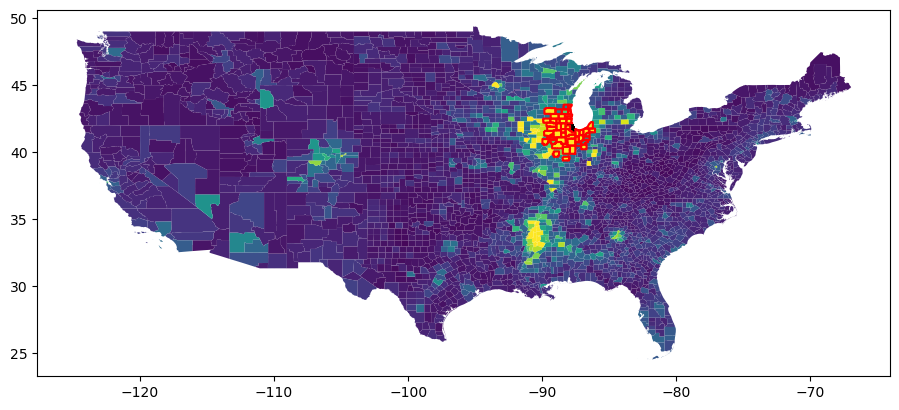

In [23]:
plot_suprising_counties(sci_dist_df, 17031, 'resid', 50)

This model favors nearby counties, missing the counties in Mississippi we're interested in. This could be because of non-linearities in the relationship between friendship and geographical distance. Really, the relationship between social distance and geographical distance is nonlinear, such that social distances decrease rapidly at first and more slowly later. Modeling this relationship as linear leads to systematic errors in the model, depending on geographical distance. Let's try a regression capable of modeling these non-linearities: a K-nearest neighbors regression should do the trick.

In [24]:
n_neighbors = 100000
knn_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=50, weights='uniform')
# X = sci_dist_df[['log_geo_dist','log_pairdensity']]
X = sci_dist_df[['geo_dist']]
y = sci_dist_df['SCI']
results = knn_model.fit(X, y)

In [25]:
if n_neighbors < 20:
    predictions = knn_model.predict(X)
    residuals = y - predictions
    sci_dist_df['knn_resid'] = residuals
else:
    # predict in batches (to avoid memory error)
    batch_size = 1000
    batches = np.arange(0, sci_dist_df.shape[0], batch_size)
    batches = batches[:-1] #remove last batch
    sci_dist_df.reset_index(inplace=True, drop=True)
    sci_dist_df['knn_resid'] = np.nan
    for batch in tqdm(batches, total=len(batches)):
        Xx = X[batch:batch+batch_size]
        Yy = y[batch:batch+batch_size]
        predictions = knn_model.predict(Xx)
        sci_dist_df.loc[batch:batch+batch_size-1, 'knn_resid'] = np.asarray(Yy - predictions)

    Xx = X[batch+batch_size:]
    Yy = y[batch+batch_size:]
    predictions = knn_model.predict(Xx)
    sci_dist_df.loc[batch+batch_size:, 'knn_resid'] = np.asarray(Yy - predictions)

100%|██████████████████████████████████████████████████████████████████████████████| 9487/9487 [02:30<00:00, 62.98it/s]


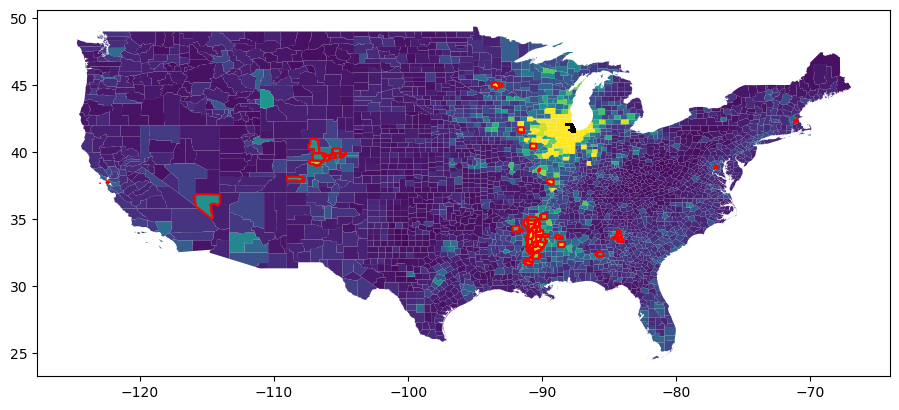

In [26]:
plot_suprising_counties(sci_dist_df, 17031, 'knn_resid', n_counties=50)

These results are much better!

Finally, I think one more method might have success: predicting the social connectedness using the social connectedness of nearby counties. Here, we can use another knn algorithm, except including the geographical longitudinal and latitudinal coordinates of the county pair. In effect, the model will use the SCI of counties adjacent to the user and fr counties.

Unfortunately, this algorithm takes ~10 hours to run, so to avoid having to run it yourself, I've saved the results as knn_xy_resid. I'd recommend setting run_knn_xy to false and loading this data in.

In [27]:
run_knn_xy = False
if run_knn_xy:
    # Get x, y coords
    county_data = pd.read_csv('G:\My Drive\ds_projects\cdcs-social-vulnerability-index-svi-2016-overall-svi-county-level.csv')
    county_data['geometry'] = county_data['geometry'].apply(wkt.loads)
    county_data = geopandas.GeoDataFrame(county_data)

    # Convert r Polygon text to shapely polygon
    for row_idx, row in county_data.iterrows():
        points = re.findall(r'-?\d+.\d+', row['geometry'].wkt)
        i = 0
        list_points = []
        while i < len(points):
            list_points.append((float(points[i]), float(points[i+1])))
            i+=2
        list_points

        county_shape = Polygon(list_points)
        county_center = county_shape.centroid
        center_points = re.findall(r'-?\d+.\d+', county_center.wkt)
        county_data.at[row_idx, 'center_long'] = float(center_points[0])
        county_data.at[row_idx, 'center_lat'] = float(center_points[1])
    
    #join coord data
    county_data = county_data.set_index('fips')
    center_loc = county_data.loc[:, ['center_long', 'center_lat']]
    sci_dist_df = sci_dist_df.set_index('user_loc')
    sci_dist_df = sci_dist_df.join(center_loc, how='left')
    sci_dist_df['user_loc'] = sci_dist_df.index
    sci_dist_df = sci_dist_df.rename(columns={'center_long':'user_center_long', 'center_lat':'user_center_lat'})
    sci_dist_df = sci_dist_df.set_index('fr_loc')
    sci_dist_df = sci_dist_df.join(center_loc, how='left')
    sci_dist_df['fr_loc'] = sci_dist_df.index
    sci_dist_df = sci_dist_df.rename(columns={'center_long':'fr_center_long', 'center_lat':'fr_center_lat'})
    
    #run model, predict SCI
    n_neighbors = 10000
    knn_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=n_neighbors, weights='uniform')
    X = sci_dist_df[['user_center_long','user_center_lat','fr_center_long','fr_center_lat']]
    y = sci_dist_df['SCI']
    results = knn_model.fit(X, y)

    if n_neighbors < 25:
        predictions = knn_model.predict(X)
        residuals = y - predictions
        sci_dist_df['knn_xy_resid'] = residuals

    else: #predict in batch to avoid memory error
        batch_size = 1000
        batches = np.arange(0, sci_dist_df.shape[0], batch_size)
        batches = batches[:-1] #remove last batch
        sci_dist_df.reset_index(inplace=True, drop=True)
        sci_dist_df['knn_resid'] = np.nan
        for batch in tqdm(batches, total=len(batches)):
            Xx = X[batch:batch+batch_size]
            Yy = y[batch:batch+batch_size]
            predictions = knn_model.predict(Xx)
            sci_dist_df.loc[batch:batch+batch_size-1, 'knn_xy_resid'] = np.asarray(Yy - predictions)

        Xx = X[batch+batch_size:]
        Yy = y[batch+batch_size:]
        predictions = knn_model.predict(Xx)
        sci_dist_df.loc[batch+batch_size:, 'knn_xy_resid'] = np.asarray(Yy - predictions)
        
else:
    knn_xy_resid = np.load('knn_xy_resid.npy')
    sci_dist_df['knn_xy_resid'] = knn_xy_resid

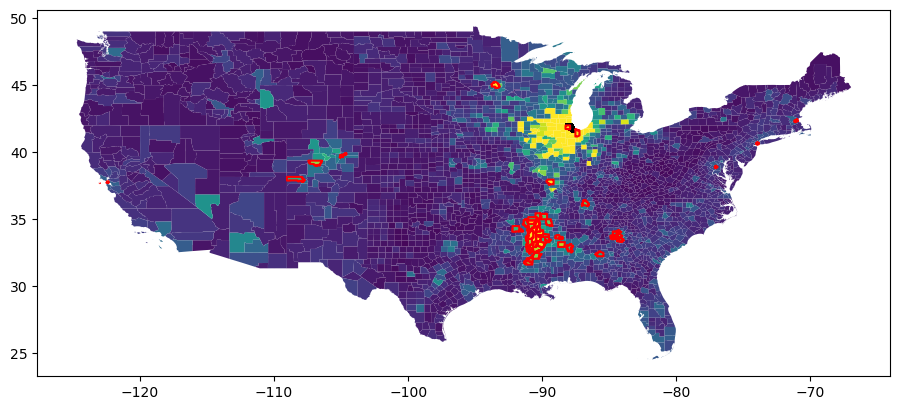

In [52]:
plot_suprising_counties(sci_dist_df, 17031, 'knn_xy_resid', n_counties=50)

This model, in my opinion, does well too. One difference is for cities, the model is more likely to select adjacent counties as suprisingly connected. This is likely because for a city, counties in the suburbs all contain commuters to the city. These commuters might be more likely to make friends with people in the city than people in other distant suburbs.

Overall, for looking for surprisingly connected counties, I'll go with the original knn model, since adjacent counties aren't exactly what I had in mind, but I think both models perform well.

Let's plot other interesting relationships for the original knn model:

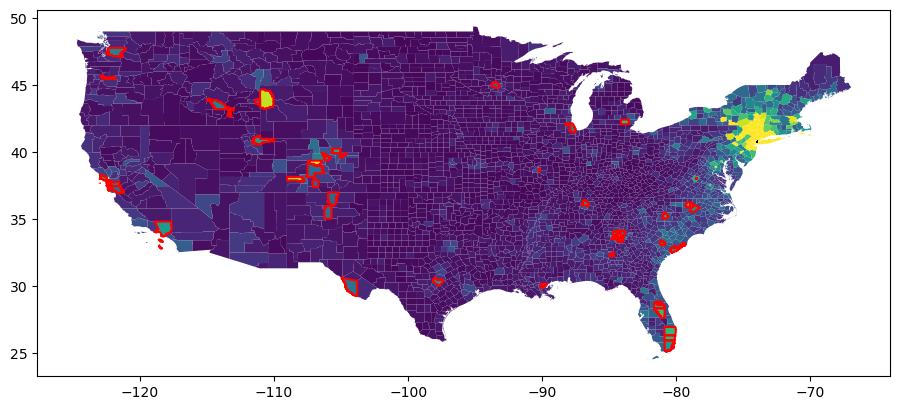

In [29]:
#Manhattan
plot_suprising_counties(sci_dist_df, 36061, 'knn_resid', n_counties=50)

Manhattan is largely linked with cities (LA, Atlanta, Autisn TX, New Orleans, Chicago, DC, Seattle, NYC, San Fransisco, Detroit), some other wealthy areas (Jackson Hole WY, some counties with ski resorts in CO), and counties in eastern florida, probably due to retirees.

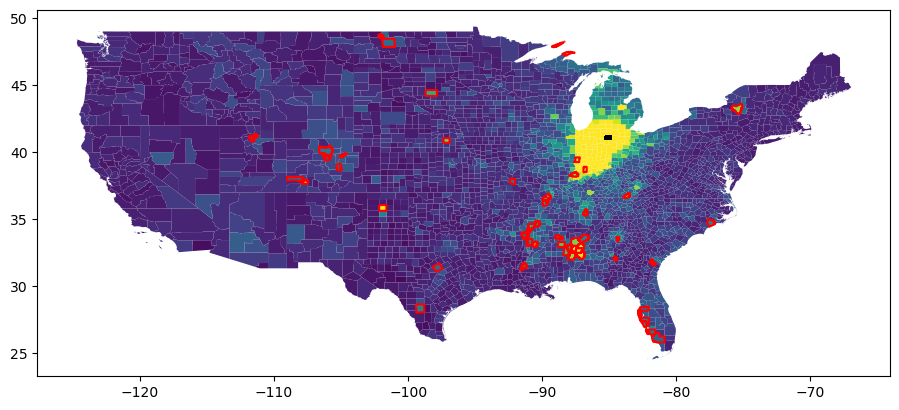

In [30]:
plot_suprising_counties(sci_dist_df, 18003, 'knn_resid', n_counties=50)

Fort Wayne is connected with Florida too, except specifically counties on the west side, rather than the east. Historically, people from the northeast travelled to Florida along I-95, which goes through the east coast of Florida and settled there, while people in the midwest and west travelled using I-75, which travels through the west coast of Florida.

Fort Wayne is also uniquely connected to counties in Alabama and Mississippi, likely due to the great migration as well.plot_suprising_counties(sci_dist_df, 18003, 'knn_resid', n_counties=50)

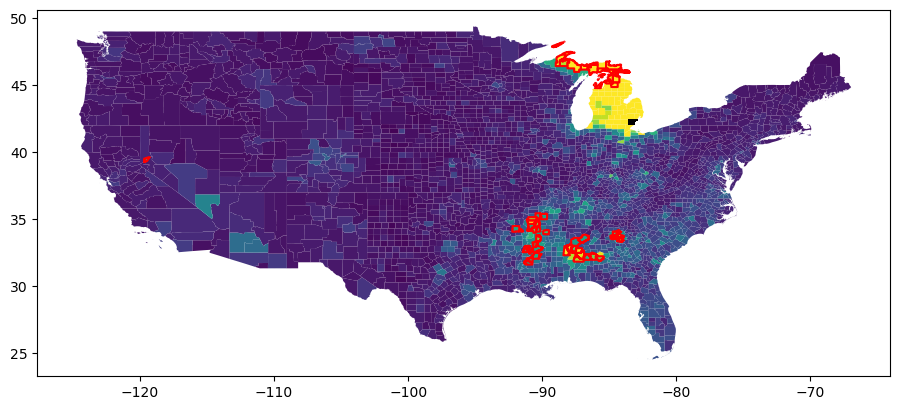

In [42]:
plot_suprising_counties(sci_dist_df, 26163, 'knn_resid', n_counties=50)

Detroit is linked with both those counties in Mississippi, and counties in Alabama. Also with counties in the upper peninsula, where some people from Detroit vacation.

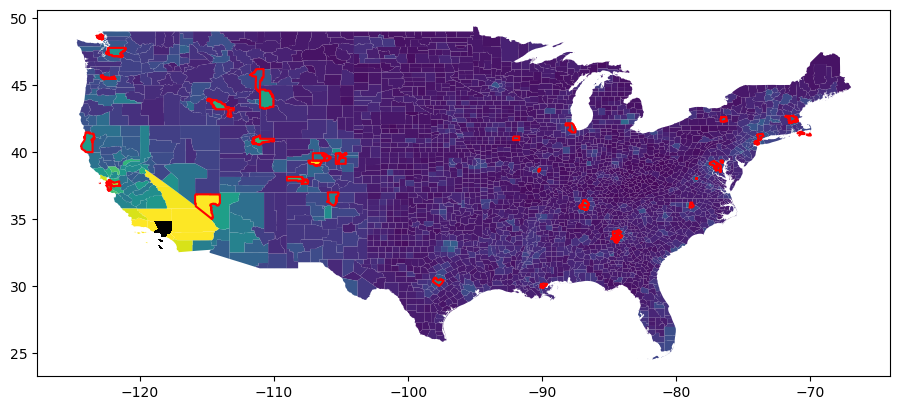

In [33]:
#LA
plot_suprising_counties(sci_dist_df, 6037, 'knn_resid', n_counties=50)

Again, we see links with other large cities (Autisn TX, New Orleans, Chicago, DC, Seattle, NYC, San Fransisco), as well as some other wealthy areas (Jackson Hole WY, some counties with ski resorts in CO)

We can also algorithmically find interesting relationships, by looking at the counties with the highest residuals.

In [34]:
density_info = pd.read_excel(r'C:\Users\mgm24\Documents\datasets\URAmericaMapCountyList.xlsx', header=3, index_col='CountyFIPS') #index_col='CountyFIPS'
density_info = density_info.loc[:, 'Population2016']
# density_info = density_info.loc[:, 'Density2016_SqMi']
sci_dist_df = sci_dist_df.set_index('user_loc')
sci_dist_df = sci_dist_df.join(density_info, how='left')
sci_dist_df['user_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.rename(columns={'Population2016':'user_pop'})
sci_dist_df = sci_dist_df.set_index('fr_loc')
sci_dist_df = sci_dist_df.join(density_info, how='left')
sci_dist_df['fr_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.rename(columns={'Population2016':'fr_pop'})
# sci_dist_df['pairdensity_avg'] = (sci_dist_df['user_density'] + sci_dist_df['fr_density']) / 2

In [35]:
# Filter on avg pop
dist = np.percentile(sci_dist_df['geo_dist'], 50)
geofar_df = sci_dist_df[sci_dist_df['geo_dist']>dist]
sci_dist_df['avg_pop'] = (sci_dist_df['user_pop']+sci_dist_df['fr_pop'])/2
pop = np.percentile(sci_dist_df['avg_pop'], 50)
dist = np.percentile(sci_dist_df['geo_dist'], 50)
filtdist_df = sci_dist_df[sci_dist_df['geo_dist']>dist]
filtdistpop_df = filtdist_df[filtdist_df['avg_pop']>pop]

filtdistpop_df.sort_values('knn_resid', ascending=False)[['user_loc','user_county','user_state','fr_county','fr_state']].head(10)

,user_loc,user_county,user_state,fr_county,fr_state
26005,31005,Arthur,NEBRASKA,Allegan,MICHIGAN
31005,26005,Allegan,MICHIGAN,Arthur,NEBRASKA
38035,48283,La Salle,TEXAS,Grand Forks,NORTH DAKOTA
48283,38035,Grand Forks,NORTH DAKOTA,La Salle,TEXAS
38085,35031,McKinley,NEW MEXICO,Sioux,NORTH DAKOTA
35031,38085,Sioux,NORTH DAKOTA,McKinley,NEW MEXICO
4001,46031,Corson,SOUTH DAKOTA,Apache,ARIZONA
46031,4001,Apache,ARIZONA,Corson,SOUTH DAKOTA
51530,49049,Utah,UTAH,Buena Vista City,VIRGINIA
49049,51530,Buena Vista City,VIRGINIA,Utah,UTAH


One interesting pairing: Utah, Utah and Buena Vista City:

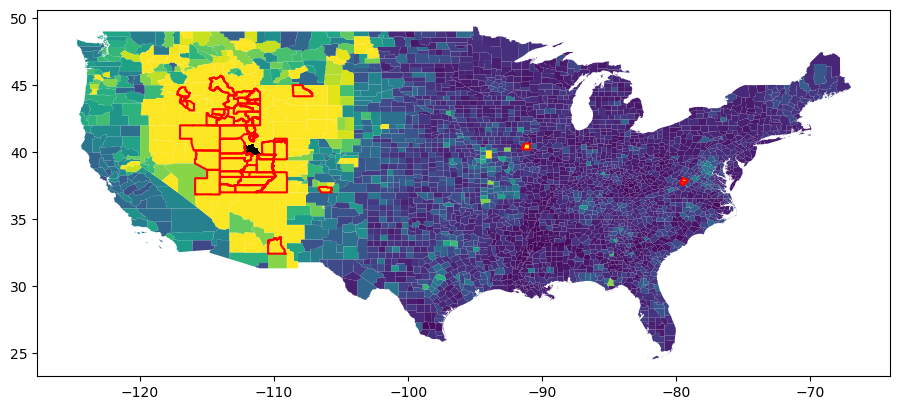

In [57]:
plot_suprising_counties(sci_dist_df, 49049, 'knn_resid', n_counties=50)

It turns out, Buena Vista City Virginia is home to Southern Virginia University, a [Mormon University](https://archive.sltrib.com/article.php?id=9363275&itype=NGPSID)!

Now, let's filter the data to see if we get more interesting results after filtering on each population:

In [37]:
# Filter on each pop
dist = np.percentile(sci_dist_df['geo_dist'], 50)
geofar_df = sci_dist_df[sci_dist_df['geo_dist']>dist]
sci_dist_df['avg_pop'] = (sci_dist_df['user_pop']+sci_dist_df['fr_pop'])/2
pop = np.percentile(sci_dist_df['avg_pop'], 50)
dist = np.percentile(sci_dist_df['geo_dist'], 50)
filtpop_df = sci_dist_df[sci_dist_df['user_pop']>pop]
filtpop_df = filtpop_df[filtpop_df['fr_pop']>pop]
filtpopdist_df = filtpop_df[filtpop_df['geo_dist']>dist]

filtpopdist_df.sort_values('knn_resid', ascending=False)[['user_loc','user_county','user_state','fr_county','fr_state']].head(10)

,user_loc,user_county,user_state,fr_county,fr_state
55075,28113,Pike,MISSISSIPPI,Marinette,WISCONSIN
28113,55075,Marinette,WISCONSIN,Pike,MISSISSIPPI
53035,13039,Camden,GEORGIA,Kitsap,WASHINGTON
13039,53035,Kitsap,WASHINGTON,Camden,GEORGIA
48027,13179,Liberty,GEORGIA,Bell,TEXAS
13179,48027,Bell,TEXAS,Liberty,GEORGIA
35009,12091,Okaloosa,FLORIDA,Curry,NEW MEXICO
12091,35009,Curry,NEW MEXICO,Okaloosa,FLORIDA
13179,36045,Jefferson,NEW YORK,Liberty,GEORGIA
36045,13179,Liberty,GEORGIA,Jefferson,NEW YORK


One interesting pairing: Camden county Georgia and Kitsap Washington. 

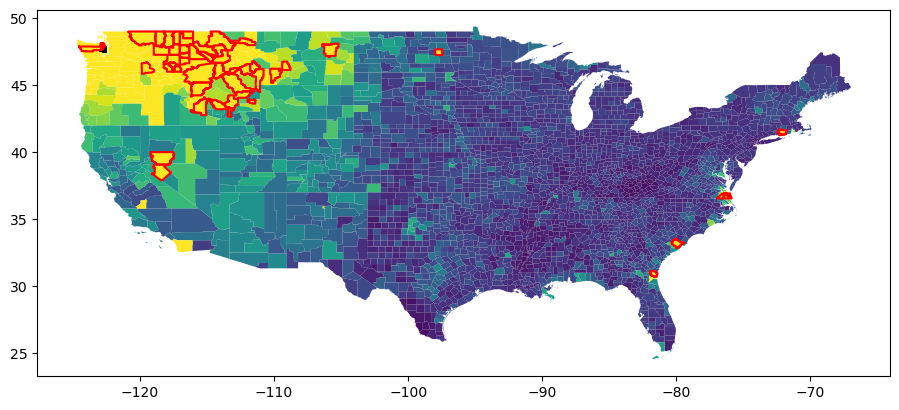

In [58]:
plot_suprising_counties(sci_dist_df, 53035, 'knn_resid', n_counties=50)

Turns out they both have a naval base! (Groton Connecticut, also highlighted, has one too!)

In [39]:
# save plots
def plot_suprising_counties(sci_dist_df, user_loc, resid, n_counties=10):
    tc_df = sci_dist_df[sci_dist_df['user_loc']==user_loc]
    fig, ax = plt.subplots(figsize=(11,10))
    tc_df.plot('SCI', ax=ax, vmin=0, vmax=10000)
    tc_df.sort_values(resid, ascending=False).head(n_counties).boundary.plot(color='red', ax=ax)
    tc_df = sci_dist_df[sci_dist_df['fr_loc']==user_loc].plot(color='black', ax=ax)
    ax.savefig(

SyntaxError: unexpected EOF while parsing (625126118.py, line 8)

In [60]:
sci_dist_df.columns

Index(['value', 'geo_dist', 'SDI', 'SCI', 'log_geo_dist', 'log_SCI',
       'log_log_SCI', 'resid', 'user_county', 'user_state', 'fr_county',
       'fr_state', 'geometry', 'knn_resid', 'knn_xy_resid', 'user_pop',
       'user_loc', 'fr_pop', 'fr_loc', 'avg_pop'],
      dtype='object')

In [ ]:
save_df = sci_dist_df.drop(columns=['value','geo_dist','SDI','log_geo_dist','log_SCI','log_log_SCI','resid'])

In [63]:
save_df.to_pickle('resid_df.pkl')

TODO:
2. Save figures / finish readme
3. Get everything publishable!